In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json 
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import make_pipeline

## Scaling + PCA Training and Fitting with MLFlow

In [0]:
import mlflow

class FSPModel(mlflow.pyfunc.PythonModel):
        def __init__(self, params):
            """Initializing with model hyperparameters and configuration"""

            self.params = params
            self.model = None
            self.config = None
        
        def load_context(self, context = None, config_path = None):
            """
            When loading a pyfunc, this method runs automatically with the related
            context.  This method is designed to perform the same functionality when
            run in a notebook or a downstream operation (like a REST endpoint).
            If the `context` object is provided, it will load the path to a config from 
            that object (this happens with `mlflow.pyfunc.load_model()` is called).
            If the `config_path` argument is provided instead, it uses this argument
            in order to load in the config.
            """
            if context: # Server run
                config_path = context.artifacts['config_path']
            else: #Notebook run
                pass

            self.config = json.load(open(config_path))

        def fit(self, model_input, target):
            """
            Uses the preprocessing function from above, initiating the setup, and fitting the model
            """
            from sklearn.ensemble import ExtraTreesClassifier

            model = ExtraTreesClassifier(**self.params)
            model.fit(model_input, target)
            self.model = model

        def predict(self, context, model_input):
            return self.model.predict(model_input)



class PCAModel(mlflow.pyfunc.PythonModel):
        """Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
Model was missing function: predict. Not logging python_function flavor! """

        def __init__(self, params):

            """Initialize with model hyperparameters. In the case of PCA for this model, there really aren't that many that I'm using. 
            In this case, I'm mostly using the n_components = 0.999"""
            
            self.params = params
            self.pca_model = None
            self.config = None
        
        def load_context(self, context = None, config_path = None):
            """
            When loading a pyfunc, this method runs automatically with the related
            context.  This method is designed to perform the same functionality when
            run in a notebook or a downstream operation (like a REST endpoint).
            If the `context` object is provided, it will load the path to a config from 
            that object (this happens with `mlflow.pyfunc.load_model()` is called).
            If the `config_path` argument is provided instead, it uses this argument
            in order to load in the config.
            """
            if context: # Server run
                config_path = context.artifacts['config_path']
            else: #Notebook run
                pass

            self.config = json.load(open(config_path))
        
        def preprocess_input(self, model_input):
            """
            Returns the input for the data.
            In this case, this is everything after loading the data. 
            Removing the one-hot encoding of the defect labels, droping the one-hot 
            encoded columns, only keeping the most common defects of 'Bumps', 'K_Scatch', or 'Z_Scratch'.
            
            Essentially the model_input is the sparktable to pandas dataframe. model_output = features_df from previous iteration.
            Output will be the features_df from the model testing phase
            """
            # Copying the input data
            processed_input = model_input.copy()

            # Collapsing the one-hot encoding
            labels = (processed_input[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']].astype('int')).idxmax(1)
            processed_input['Labels'] = labels
            
            # Dropping the one-hot encoded columns
            processed_input = processed_input.drop(['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains','Dirtiness', 'Bumps', 'Other_Faults'], axis = 1)

            # Only including the top 3 datapoints
            top_defects = processed_input[(processed_input['Labels']=='Bumps')|(processed_input['Labels']=='K_Scatch')|(processed_input['Labels']=='Z_Scratch')]

            return top_defects

        def pca_fit(self, model_input):
            """ Fitting the PCA outside of the PyCaret package. This will allow
            me to plot the PCA components separately"""
            # Preprocessing the data
            processed_model_input = self.preprocess_input(model_input)
            
            # Removing the Label column so it doesn't go through the PCA process
            processed_model_input = processed_model_input[processed_model_input.columns[processed_model_input.columns!='Labels']]
            print(processed_model_input)
            with mlflow.start_run(run_name = 'PCA'):
                mlflow.autolog()

                # Using the Standard Scaler to scale data to mean 0 and unit variance of 1.
                scaler = StandardScaler()

                # PCA and identified parameters
                pca = PCA(**self.params)

                # Pipelining these together
                pipeline = make_pipeline(scaler, pca)
                pipeline.fit_transform(processed_model_input)
                

                # PCA Output with the features, variance ratio, and cumulative variance ratios
                features = range(pca.n_components_)
                pca_output_df = (pd.DataFrame(zip(features, np.cumsum(pca.explained_variance_ratio_), pca.explained_variance_ratio_), 
                                columns = ['Features', 'Cumulative Variance', 'Variance']))

                pca_output_df_path = "pca_output.csv"
                pca_output_df.to_csv(pca_output_df_path, index = False)
                # Put the artifact in the model folder
                mlflow.log_artifact(pca_output_df_path, 'artifacts')
                
                # Figure that shows the variance ratios and cumulative variance outcomes of the PCA
                fig, ax = plt.subplots()
                line1 = ax.bar(x = pca_output_df['Features'], height = pca_output_df['Variance'])
                ax.set_ylabel('Variance')
                ax.set_xlabel('PCA Feature')
                ax2 = ax.twinx()
                line2, = ax2.plot(pca_output_df['Features'], pca_output_df['Cumulative Variance'], marker = 'o', color = '#daa520')
                ax2.set_ylabel('Cumulative Variance')
                plt.title("Importance and Variance of the Principal Components")
                plt.grid(False)
                mlflow.log_figure(fig, "artifacts/Variance_Importances.png")

                # PCA Components weighted by Tag where Columns = pca components, rows the name of the column
                pca_summary = pd.DataFrame(np.abs(pca.components_)).T
                pca_summary.columns = ['pc{}'.format(i+1) for i in range(len(pca.components_))]
                pca_summary['Original Tag'] = processed_model_input.columns
                pca_summary_plot = pca_summary.copy()
                pca_length = len(pca.components_)
                pca_summary_plot.iloc[:, :pca_length] = np.round(pca_summary_plot.iloc[:, :pca_length], 3)
                pca_summary_path = "pca_summary.csv"
                pca_summary_plot.to_csv(pca_summary_path, index = False)
                mlflow.log_artifact(pca_summary_path, 'artifacts')

                # Outputting the PC from the fit data
                principalDf = pd.DataFrame(data = pipeline.transform(processed_model_input))
                # Renaming principal dataframe columns for easier reading
                new_cols = ['pc{}'.format(i+1) for i in range(len(principalDf.columns))]
                principalDf.columns = new_cols
                # Plotting as a function of time with the input dataset's index
                principalDf.index = processed_model_input.index
                principalDf_path = 'principal_components_time_index.csv'
                principalDf.to_csv(principalDf_path)
                mlflow.log_artifact(principalDf_path, 'artifacts')

            self.pca_model = pipeline

        def predict(self, context, model_input):   
            """ Main entrance to the model in deployment system 
            Since this is PCA, the intended method is transform. However, pyfunc MLModel doesn't
            have that function encoded. It has 'predict' instead so I'm using the 'predict' in 
            order to start the pca 'transform' """
            processed_model_input = self.preprocess_input(model_input.copy())

            # Return pca transform on all rows except for label
            return self.pca_model.transform(processed_model_input.iloc[:, :-1])



## Establishing Context

In [0]:
import json 
import os

pca_params = {
    "n_components": 0.999,
}

et_params = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.001,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 5907,
 'verbose': 0,
 'warm_start': False}

# Designate a path -- Ask Avi about this: Can you have more than one config path?
pca_config_path = "./pca_config.json"
et_config_path = "./et_config.json"

# Save the results for both models
with open(pca_config_path, "w") as f:
    json.dump(pca_params, f)

with open(et_config_path, "w") as f:
    json.dump(et_params, f)

# Generate an artifact object to saved
# All paths to the associated values will be copied over when saving
pc_artifacts = {"config_path": pca_config_path} 
et_artifacts = {"config_path": et_config_path}

## Transforming Data and Training the PCA Model

{'n_components': 0.999}
     X_Minimum X_Maximum Y_Minimum Y_Maximum Pixels_Areas X_Perimeter  \
158       1166      1185   2258648   2258662          123          33   
159          7        19     21512     21518           56          13   
160         37        53     50442     50467          226          33   
161         39        51     66522     66578          436          41   
162        193       205     82308     82319           84          19   
...        ...       ...       ...       ...          ...         ...   
1263       221       242   3948212   3948253          519          33   
1264      1111      1121   4032298   4032320          110          20   
1265       995      1006   4085316   4085344          140          25   
1266       396       418   4116853   4116868          231          26   
1267       604       646   4441757   4441811         1035          67   

     Y_Perimeter Sum_of_Luminosity Minimum_of_Luminosity  \
158           17             15858     

2023/06/14 19:02:04 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2023/06/14 19:02:04 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/06/14 19:02:04 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/06/14 19:02:04 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2023/06/14 19:02:04 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.
2023/06/14 19:02:04 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/06/14 19:02:04 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2023/06/14 19:02:04 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python

Out[128]: array([[-2.9069898 , -0.0483719 ,  0.9956428 , ..., -0.16640622,
        -0.26042845,  0.12210778],
       [-2.39997205, -1.37135776, -0.07557473, ..., -0.23563948,
        -0.26893678,  0.31270924],
       [-1.08904031,  1.1222131 , -0.56385809, ..., -0.01628352,
         0.15463496, -0.05131389],
       ...,
       [-3.07280911,  1.91038225, -1.02419003, ...,  0.06216951,
        -0.13942337,  0.04250059],
       [-2.29130711, -0.67440995, -1.13536022, ..., -0.23929558,
        -0.11104346, -0.096534  ],
       [-1.41868868,  1.45560473, -2.04254939, ..., -0.25013889,
        -0.23041414,  0.0599727 ]])

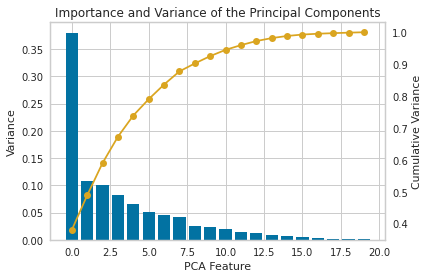

In [0]:
pca_model = PCAModel(pca_params)

# Load the context
pca_model.load_context(config_path = pca_config_path)

# Print out the params going into the model
print(pca_model.config)

model_data = spark.table('FSP.faults').toPandas()

# Fitting the PCA model
pca_model.pca_fit(model_data)

# Transforming the PCA model
pc_out = pca_model.predict(model_input = model_data, context = None)
pc_out

## Fitting, Predicting, and Logging the Extra Trees Model
This was the model that was shown to be the strongest in the testing phase

In [0]:
# Extracting the labels from the preprocessing of the PCA model
labels = PCAModel(pca_params).preprocess_input(model_input = model_data)[['Labels']].reset_index(drop = True)
labels

,Labels
0,Z_Scratch
1,Z_Scratch
2,Z_Scratch
3,Z_Scratch
4,Z_Scratch
...,...
978,Bumps
979,Bumps
980,Bumps
981,Bumps


In [0]:
# Turn the array of principal components into a pandas dataframe
pc_df = pd.DataFrame(pc_out)

# Merge the two to become the model input for the extra trees
model_df = pd.concat([pc_df, labels], axis = 1)
model_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,Labels
0,-2.906990,-0.048372,0.995643,1.336856,-0.936570,-0.442275,-2.797436,0.984892,-0.365213,0.322788,...,-0.777683,0.416145,-0.539938,0.227276,-0.068436,-0.098604,-0.166406,-0.260428,0.122108,Z_Scratch
1,-2.399972,-1.371358,-0.075575,-1.211437,-1.585174,2.975480,0.992249,0.375914,-0.176401,-0.072215,...,-0.044239,-0.890398,-0.130865,0.011387,-0.126468,-0.079212,-0.235639,-0.268937,0.312709,Z_Scratch
2,-1.089040,1.122213,-0.563858,-2.513436,0.137316,1.208265,-0.294876,-0.212721,-0.088112,-0.296522,...,0.131357,-0.415378,0.325716,-0.394717,-0.115116,0.142313,-0.016284,0.154635,-0.051314,Z_Scratch
3,-0.620656,2.068119,-2.338118,-2.789143,0.537352,0.308699,1.017604,0.333179,-1.275999,-0.037854,...,-0.204878,-0.857907,-0.083951,0.336192,-0.225967,0.298791,-0.108318,0.291593,0.109723,Z_Scratch
4,-2.291704,-0.076978,-0.432005,-1.079407,-1.319432,1.904027,0.085706,-0.369679,1.187587,-0.492957,...,-0.188158,-0.638684,-0.341019,0.546975,-0.608499,-0.032807,-0.208120,-0.316238,-0.015386,Z_Scratch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,-1.539766,1.447195,-2.653171,0.185517,1.899059,0.152564,-0.555855,1.172670,0.676488,3.619030,...,0.379077,-0.701449,0.842953,0.045985,-0.203745,-0.005970,-0.031869,0.299434,0.086055,Bumps
979,-3.371940,1.815376,-1.176631,0.853082,2.070384,-0.728439,-1.283543,2.725147,1.178230,2.050438,...,0.488387,-0.411145,-0.428316,-0.090951,0.042682,-0.233251,0.080952,-0.199890,-0.035455,Bumps
980,-3.072809,1.910382,-1.024190,0.592089,2.387984,-0.686450,-1.631045,2.841445,0.841456,2.379709,...,0.509752,-0.368856,-0.413309,0.012374,0.029905,-0.189570,0.062170,-0.139423,0.042501,Bumps
981,-2.291307,-0.674410,-1.135360,1.649346,0.417604,1.045489,-0.914615,1.238473,1.343785,3.932371,...,0.192995,-1.511762,0.058856,0.267159,0.336933,0.100777,-0.239296,-0.111043,-0.096534,Bumps


In [0]:
et_model = FSPModel(et_params)

# Load the context
et_model.load_context(config_path = et_config_path)

et_model.fit(pc_df, labels)
pred = et_model.predict(model_input = pc_df, context = None)
pred[:6]


2023/06/14 19:30:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8c7da88b771046a9bc84010474c85278', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/06/14 19:30:51 WARNING mlflow.sklearn.utils: roc_auc_score failed. The metric training_roc_auc will not be recorded. Metric error: Encoders require their input to be uniformly strings or numbers. Got ['ndarray']


Out[138]: array(['Bumps', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch',
       'Z_Scratch'], dtype=object)

In [0]:
model_data

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.215,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,249,277,325780,325796,273,54,22,35033,119,141,...,-0.4286,0.0026,0.7254,0,0,0,0,0,0,1
1937,144,175,340581,340598,287,44,24,34599,112,133,...,-0.4516,-0.0582,0.8173,0,0,0,0,0,0,1
1938,145,174,386779,386794,292,40,22,37572,120,140,...,-0.4828,0.0052,0.7079,0,0,0,0,0,0,1
1939,137,170,422497,422528,419,97,47,52715,117,140,...,-0.0606,-0.0171,0.9919,0,0,0,0,0,0,1


## Generating Signatures for Both Models

In [0]:
from mlflow.models.signature import infer_signature

# Signature for the PCA
pca_signature = infer_signature(model_data, pc_out)
print(pca_signature)

# Signature for the extra trees model
et_signature = infer_signature(pc_df, pred)
print(et_signature)

inputs: 
  ['X_Minimum': string, 'X_Maximum': string, 'Y_Minimum': string, 'Y_Maximum': string, 'Pixels_Areas': string, 'X_Perimeter': string, 'Y_Perimeter': string, 'Sum_of_Luminosity': string, 'Minimum_of_Luminosity': string, 'Maximum_of_Luminosity': string, 'Length_of_Conveyer': string, 'TypeOfSteel_A300': string, 'TypeOfSteel_A400': string, 'Steel_Plate_Thickness': string, 'Edges_Index': string, 'Empty_Index': string, 'Square_Index': string, 'Outside_X_Index': string, 'Edges_X_Index': string, 'Edges_Y_Index': string, 'Outside_Global_Index': string, 'LogOfAreas': string, 'Log_X_Index': string, 'Log_Y_Index': string, 'Orientation_Index': string, 'Luminosity_Index': string, 'SigmoidOfAreas': string, 'Pastry': string, 'Z_Scratch': string, 'K_Scatch': string, 'Stains': string, 'Dirtiness': string, 'Bumps': string, 'Other_Faults': string]
outputs: 
  [Tensor('float64', (-1, 20))]

inputs: 
  [0: double, 1: double, 2: double, 3: double, 4: double, 5: double, 6: double, 7: double, 8: doubl

## Generating Conda Environment

In [0]:
from sys import version_info
import sklearn

conda_env = {
    "channels": ["defaults"],
    "dependencies": [
        f"python={version_info.major}.{version_info.minor}.{version_info.micro}",
        "pip",
        {"pip": ["mlflow",
                 f"scikit-learn=={sklearn.__version__}"]
        },
    ],
    "name": "sklearn_env"
}

conda_env

Out[134]: {'channels': ['defaults'],
 'dependencies': ['python=3.9.5',
  'pip',
  {'pip': ['mlflow', 'scikit-learn==1.0.2']}],
 'name': 'sklearn_env'}

## Saving and Loading the Models

## PCA

In [0]:
# Saving the PCA model
with mlflow.start_run() as pca_run:
    mlflow.pyfunc.log_model(
        'FSP_pca',
        python_model=pca_model, 
        artifacts = pc_artifacts, 
        conda_env = conda_env,
        signature = pca_signature,
        input_example = model_data[:3]
    )

In [0]:
# Loading the pc model to use
pc_mlflow_model_path = f"runs:/{pca_run.info.run_id}/FSP_pca"
pc_loaded_model = mlflow.pyfunc.load_model(pc_mlflow_model_path)
pc_loaded_model

Out[143]: mlflow.pyfunc.loaded_model:
  artifact_path: FSP_pca
  flavor: mlflow.pyfunc.model
  run_id: bfbd9dc4d6cb4605a4bdaad1b1f8a218

In [0]:
pc_loaded_model.predict(model_data)

Out[145]: array([[-2.9069898 , -0.0483719 ,  0.9956428 , ..., -0.16640622,
        -0.26042845,  0.12210778],
       [-2.39997205, -1.37135776, -0.07557473, ..., -0.23563948,
        -0.26893678,  0.31270924],
       [-1.08904031,  1.1222131 , -0.56385809, ..., -0.01628352,
         0.15463496, -0.05131389],
       ...,
       [-3.07280911,  1.91038225, -1.02419003, ...,  0.06216951,
        -0.13942337,  0.04250059],
       [-2.29130711, -0.67440995, -1.13536022, ..., -0.23929558,
        -0.11104346, -0.096534  ],
       [-1.41868868,  1.45560473, -2.04254939, ..., -0.25013889,
        -0.23041414,  0.0599727 ]])

## Extra Trees

In [0]:
# Saving the ET model
with mlflow.start_run() as et_run:
    mlflow.pyfunc.log_model(
        'FSP_et',
        python_model=et_model, 
        artifacts = et_artifacts, 
        conda_env = conda_env,
        signature = et_signature,
        input_example = pc_df[:3]
    )

In [0]:
# Loading the pc model to use
et_loaded_model = mlflow.pyfunc.load_model(f"runs:/{et_run.info.run_id}/FSP_et")
et_loaded_model.predict(pc_out)

Out[173]: array(['Bumps', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch',
       'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch',
       'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch',
       'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch',
       'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch',
       'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch',
       'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch',
       'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch',
       'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch',
       'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch',
       'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch',
       'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch',
       'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch',
       'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch',

## Registering both models

In [0]:
## Uncomment below if you want to register a new version of a model instead

# pca_model_details = mlflow.register_model(model_uri=f"runs:/{pca_run.info.run_id}/FSP_pca", name="pca-fsp-model",
#                                           tags = {"description":'Words'})
# print(pca_model_details)

# et_model_details = mlflow.register_model(model_uri = f"runs:/{et_run.info.run_id}/FSP_et", name = 'et-fsp-model')
# print(et_model_details)

Registered model 'pca-fsp-model' already exists. Creating a new version of this model...
2023/06/14 20:38:14 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: pca-fsp-model, version 6
Created version '6' of model 'pca-fsp-model'.
Registered model 'et-fsp-model' already exists. Creating a new version of this model...


<ModelVersion: aliases=[], creation_timestamp=1686775094612, current_stage='None', description='', last_updated_timestamp=1686775095881, name='pca-fsp-model', run_id='bfbd9dc4d6cb4605a4bdaad1b1f8a218', run_link='', source='dbfs:/databricks/mlflow-tracking/3333224719123772/bfbd9dc4d6cb4605a4bdaad1b1f8a218/artifacts/FSP_pca', status='READY', status_message='', tags={'description': 'Words'}, user_id='admingernej@lpcorp.com', version='6'>


2023/06/14 20:38:21 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: et-fsp-model, version 2


<ModelVersion: aliases=[], creation_timestamp=1686775101269, current_stage='None', description='', last_updated_timestamp=1686775102439, name='et-fsp-model', run_id='41781beb5bb2468f945690e5beb247c2', run_link='', source='dbfs:/databricks/mlflow-tracking/3333224719123772/41781beb5bb2468f945690e5beb247c2/artifacts/FSP_et', status='READY', status_message='', tags={}, user_id='admingernej@lpcorp.com', version='2'>


Created version '2' of model 'et-fsp-model'.


In [0]:
# Adding a description to the model through MLFlowClient updating
from mlflow.tracking.client import MlflowClient

client = MlflowClient()

client.update_registered_model(
    name = "pca-fsp-model",
    description = "PCA on the Faulty Steel Plate (FSP) data "
)

client.update_registered_model(
    name = 'et-fsp-model',
    description = 'Extra trees model trained on the PCA output of the Faulty Steel Plate (FSP) data'
)

Out[196]: <RegisteredModel: aliases={}, creation_timestamp=1686772358075, description=('Extra trees model trained on the PCA output of the Faulty Steel Plate (FSP) '
 'data'), last_updated_timestamp=1686838086542, latest_versions=[], name='et-fsp-model', tags={}>

In [0]:
# Moving models to staging for testing and production for deployment
# Get latest version of the pca model
pca_model_name = 'pca-fsp-model'

# client.search_registered_models()
# client.get_latest_versions(name = 'pca-fsp-model')

pca_model_version_infos = client.search_model_versions(f"name = '{pca_model_name}'")
pca_new_model_version = max([model_version_info.version for model_version_info in pca_model_version_infos])
print(f"Latest model version: {pca_new_model_version}") 

# client.transition_model_version_stage(
#     name = pca_model_name,
#     version = pca_new_model_version, 
#     stage = 'Staging'
# )

# Only uncomment when ready for production
client.transition_model_version_stage(
    name = pca_model_name,
    version = pca_new_model_version, 
    stage = 'Production'
)



Latest model version: 6
Out[194]: <ModelVersion: aliases=[], creation_timestamp=1686775094612, current_stage='Production', description='', last_updated_timestamp=1686837080331, name='pca-fsp-model', run_id='bfbd9dc4d6cb4605a4bdaad1b1f8a218', run_link='', source='dbfs:/databricks/mlflow-tracking/3333224719123772/bfbd9dc4d6cb4605a4bdaad1b1f8a218/artifacts/FSP_pca', status='READY', status_message='', tags={}, user_id='5054961294666361', version='6'>

In [0]:
# Get latest version of the et model
et_model_name = 'et-fsp-model'

# client.search_registered_models()
# client.get_latest_versions(name = 'pca-fsp-model')

et_model_version_infos = client.search_model_versions(f"name = '{et_model_name}'")
et_new_model_version = max([model_version_info.version for model_version_info in et_model_version_infos])
print(f"Latest model version: {et_new_model_version}") 

client.transition_model_version_stage(
    name = et_model_name,
    version = et_new_model_version, 
    stage = 'Staging'
)

# Only uncomment when ready for production
client.transition_model_version_stage(
    name = et_model_name,
    version = et_new_model_version, 
    stage = 'Production'
)

Latest model version: 2
Out[195]: <ModelVersion: aliases=[], creation_timestamp=1686775101269, current_stage='Production', description='', last_updated_timestamp=1686838037203, name='et-fsp-model', run_id='41781beb5bb2468f945690e5beb247c2', run_link='', source='dbfs:/databricks/mlflow-tracking/3333224719123772/41781beb5bb2468f945690e5beb247c2/artifacts/FSP_et', status='READY', status_message='', tags={}, user_id='5054961294666361', version='2'>

## Predicting with the Production Models

In [0]:
# I'm using the original dataset just to show how to use the production model
prod_data = spark.table('FSP.faults').toPandas()

# Pulling the production PCA model
stage = 'Production'
pca_prod = mlflow.pyfunc.load_model(model_uri = f"models:/{pca_model_name}/{stage}")
print(pca_prod)

pc_prod_pred = pca_prod.predict(prod_data)
pc_prod_pred

# Pulling the production et model
et_prod = mlflow.pyfunc.load_model(model_uri = f"models:/{et_model_name}/{stage}")
print(et_prod)

et_prod_pred = et_prod.predict(pc_prod_pred)
et_prod_pred

mlflow.pyfunc.loaded_model:
  artifact_path: FSP_pca
  flavor: mlflow.pyfunc.model
  run_id: bfbd9dc4d6cb4605a4bdaad1b1f8a218

mlflow.pyfunc.loaded_model:
  artifact_path: FSP_et
  flavor: mlflow.pyfunc.model
  run_id: 41781beb5bb2468f945690e5beb247c2

Out[202]: array(['Bumps', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch',
       'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch',
       'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch',
       'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch',
       'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch',
       'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch',
       'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch',
       'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch',
       'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch',
       'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch', 'Z_Scratch',
       'Z_Scratch', '